## Steel price regression - 환율 선 적용

## 변수 정의
### 1. 국내
* weightA: 철 스크랩, 중량A 평균가

### 2. 철스크랩(Scrap Steel) > 한국의 수입가
* importPriceUSA: 미국산 대형 -벌크 (HMS No.1) (달러/톤)
* importPriceJP: 일본 H2 (백엔/톤)

### 3. 철스크랩(Scrap Steel) > 해외가격(Overseas)
* priceCN: 중국 장쑤 내수가 (달러/톤)
* priceJP: 일본 내수가 (백엔/톤)
* priceUSA_TAIWAN : 미국→대만 (컨테이너) (달러/톤)

### 4. 기타 변수
* stock: 국내 제강사 재고
* USD_KR: 달러 환율(해당일 매매기준율)
* JPY_KR: 엔화 환율(해당일 매매기준율)


### Scrap가 부서공식 
* 스크랩가 = weightA*0.7 + importPriceJP*0.2 + importPriceUSA*0.1

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# 데이터 분할:train, test
from sklearn.model_selection import train_test_split
# 분류 Random Forest
from sklearn.ensemble import RandomForestClassifier
# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV
# 모델 성능 평가
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.api import qqplot,add_constant
import statsmodels.formula.api as smf

In [3]:
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

In [4]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [5]:
import matplotlib
# 한글설치 (윈도우 버전)
matplotlib.rc('font', family = 'AppleGothic')
# 음수 표시
matplotlib.rc('axes', unicode_minus=False)
# 실행결과 경고메시지 출력 제외
import warnings
warnings.filterwarnings('ignore')
random_seed = 123
pd.set_option('display.max_rows', 500)

In [39]:
df_raw = pd.read_csv("data/step1.csv")
#날짜형으로 변환
df_raw['date'] = pd.to_datetime(df_raw['date'], format='%Y-%m-%d')
df_raw = df_raw.sort_values(by=['date'], ascending=True, ignore_index=True)
df_raw.head()
df_raw = df

In [40]:
df.corr().round(3)
#weightA를 제외한 다른 줄들에서, 한줄에 0.7이상인 값들이  많고, 다중공선성 확인 필요함

,weightA,gosi,priceUSA_TAIWAN,priceJP,priceCN,importPriceUSA,importPriceJP,stock,USD_KR,JPY_KR,scrap,stock_trend
weightA,1.000,0.896,0.937,0.959,0.768,0.952,0.940,-0.371,-0.221,-0.200,0.955,-0.599
gosi,0.896,1.000,0.804,0.816,0.827,0.832,0.785,-0.246,-0.071,-0.075,0.810,-0.598
priceUSA_TAIWAN,0.937,0.804,1.000,0.961,0.748,0.960,0.970,-0.352,-0.312,-0.220,0.978,-0.636
priceJP,0.959,0.816,0.961,1.000,0.668,0.952,0.973,-0.290,-0.406,-0.359,0.978,-0.500
priceCN,0.768,0.827,0.748,0.668,1.000,0.762,0.669,-0.370,0.185,0.308,0.708,-0.887
importPriceUSA,0.952,0.832,0.960,0.952,0.762,1.000,0.948,-0.363,-0.215,-0.190,0.977,-0.638
importPriceJP,0.940,0.785,0.970,0.973,0.669,0.948,1.000,-0.352,-0.355,-0.327,0.994,-0.530
stock,-0.371,-0.246,-0.352,-0.290,-0.370,-0.363,-0.352,1.000,-0.121,-0.224,-0.360,0.480
USD_KR,-0.221,-0.071,-0.312,-0.406,0.185,-0.215,-0.355,-0.121,1.000,0.847,-0.312,-0.266
JPY_KR,-0.200,-0.075,-0.220,-0.359,0.308,-0.190,-0.327,-0.224,0.847,1.000,-0.285,-0.468


In [41]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=1432)
print ("Train data size {}".format(df_train.shape))
print ("Test data size {}".format(df_test.shape))

Train data size (172, 13)
Test data size (75, 13)


In [42]:
#선형회귀분석
reg_model = smf.ols(formula="weightA ~ importPriceUSA + gosi + scrap + priceUSA_TAIWAN + priceJP + priceCN + importPriceJP+ stock + stock_trend + USD_KR + JPY_KR", data=df ) 
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                weightA   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.460e+26
Date:                Sat, 23 Oct 2021   Prob (F-statistic):               0.00
Time:                        18:44:21   Log-Likelihood:                 5645.1
No. Observations:                 247   AIC:                        -1.127e+04
Df Residuals:                     235   BIC:                        -1.122e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -4.979e-11   1.62e-10     

In [29]:
print('Parameters: ', reg_result.params)
print('R2: ', reg_result.rsquared)

Parameters:  Intercept         -4.979483e-11
importPriceUSA    -1.428571e-01
gosi              -1.980638e-13
scrap              1.428571e+00
priceUSA_TAIWAN    8.744633e-16
priceJP           -8.237226e-17
priceCN            8.294147e-18
importPriceJP     -2.857143e-01
stock             -1.321165e-14
stock_trend        7.716050e-14
USD_KR             2.604583e-13
JPY_KR            -1.882938e-13
dtype: float64
R2:  1.0


In [58]:
#선형회귀분석
reg_model = smf.ols(formula="gosi ~ importPriceUSA + weightA+ scrap + priceUSA_TAIWAN + priceJP + importPriceJP+ priceCN+stock + stock_trend + USD_KR + JPY_KR", data=df ) 
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   gosi   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     219.5
Date:                Sat, 23 Oct 2021   Prob (F-statistic):          1.77e-113
Time:                        19:50:16   Log-Likelihood:                -1106.3
No. Observations:                 247   AIC:                             2235.
Df Residuals:                     236   BIC:                             2273.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         127.0496    119.427     

In [61]:
#선형회귀분석
reg_model = smf.ols(formula="gosi ~ importPriceUSA + weightA+ scrap +  priceJP + importPriceJP+ priceCN+stock + stock_trend  + JPY_KR", data=df ) # + USD_KR  priceUSA_TAIWAN
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   gosi   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     275.5
Date:                Sat, 23 Oct 2021   Prob (F-statistic):          1.02e-115
Time:                        19:51:06   Log-Likelihood:                -1106.7
No. Observations:                 247   AIC:                             2231.
Df Residuals:                     238   BIC:                             2263.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        139.0442    115.694      1.

In [ ]:
#다중공선성 확인
#환율과 영향이 있는지, 환율 빼기 USD_KR, JPY_KR
df_raw_x = df_train[['importPriceUSA','priceUSA_TAIWAN','priceJP','priceCN','importPriceJP', 'stock' , 'gosi','scrap' , 'stock_trend']]
df_raw_x_const = add_constant(df_raw_x)
df_vif = pd.DataFrame()
df_vif["variable"] = df_raw_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_raw_x_const,i) for i in range(df_raw_x_const.shape[1])]
#sorting VIF
df_vif.sort_values("VIF", inplace=True)
df_vif.round(3)



In [55]:
#선형회귀분석
reg_model = smf.ols(formula="weightA ~ importPriceUSA + gosi + scrap + priceUSA_TAIWAN + priceJP + importPriceJP+ stock + stock_trend + USD_KR + JPY_KR", data=df ) 
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                weightA   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.059e+25
Date:                Sat, 23 Oct 2021   Prob (F-statistic):               0.00
Time:                        18:49:55   Log-Likelihood:                 5377.4
No. Observations:                 247   AIC:                        -1.073e+04
Df Residuals:                     237   BIC:                        -1.070e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        6.912e-11   2.62e-10     

In [57]:
#다중공선성 확인
df_raw_x = df[['importPriceUSA','scrap','priceJP','priceCN','importPriceJP','stock_trend','gosi', 'USD_KR', 'stock', 'JPY_KR']]
df_raw_x_const = add_constant(df_raw_x)
df_vif = pd.DataFrame()
df_vif["variable"] = df_raw_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_raw_x_const,i) for i in range(df_raw_x_const.shape[1])]
#sorting VIF
df_vif.sort_values("VIF", inplace=True)
df_vif.round(3)



TypeError: '(slice(None, None, None), 0)' is an invalid key

In [ ]:

# Cond. No.                    4.92e+07

In [15]:
#선형회귀분석
reg_model = smf.ols(formula="weightA ~ importPriceUSA +  priceUSA_TAIWAN + priceJP + priceCN + importPriceJP + stock_trend", data=df ) 
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                weightA   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     849.7
Date:                Sat, 23 Oct 2021   Prob (F-statistic):          1.47e-158
Time:                        15:41:14   Log-Likelihood:                -1033.9
No. Observations:                 247   AIC:                             2082.
Df Residuals:                     240   BIC:                             2106.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -29.6437     59.535     

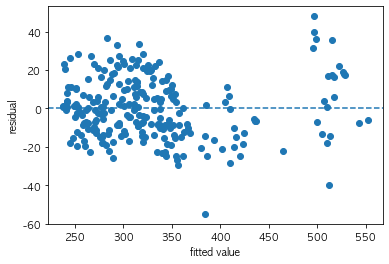

In [17]:
plt.scatter(reg_result.fittedvalues, reg_result.resid)
plt.xlabel("fitted value")
plt.ylabel("residual")
plt.axhline(y=0, linestyle="--")
#잔차가 y=0을 기준으로 Random하게 산포되어 있으므로 등분산성 만족함

In [18]:
df_train.index

Int64Index([204, 178, 138, 133, 244, 166, 167, 183, 159, 213,
            ...
            164,  27, 179, 142,  78,  81, 113, 163,  98, 200],
           dtype='int64', length=172)

In [19]:
reg_result.resid

0      20.934108
1       5.888398
2      -0.851814
3       5.793340
4       0.150365
5      -7.785863
6      -7.436408
7      -7.516994
8     -10.973323
9      -7.179473
10      0.863150
11      3.393349
12     -2.381183
13    -13.137034
14    -25.587876
15    -22.075277
16    -18.024286
17     11.193987
18      8.031007
19      3.941821
20      1.246885
21      0.938668
22     -0.902408
23      1.396902
24     10.371691
25     10.126842
26     11.259107
27     -2.050858
28     -3.281550
29    -10.998100
30     -5.623472
31     -7.369623
32     -3.227814
33     -4.689715
34    -17.637791
35      0.868666
36      8.608021
37      5.671088
38     21.188066
39     14.167743
40      9.341756
41     12.531580
42      1.320580
43     -4.228703
44      7.539269
45      8.384120
46     12.048112
47     15.967033
48     22.508838
49     28.370336
50     33.498683
51     21.822414
52     24.036079
53      6.621396
54    -14.670601
55    -24.537442
56    -24.554637
57    -26.629240
58    -29.2187

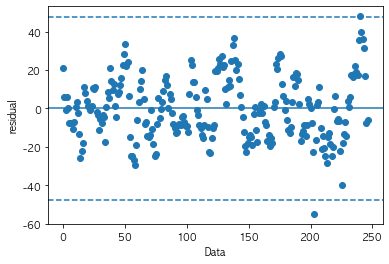

In [23]:
import numpy as np
plt.scatter(df.index, reg_result.resid, marker="o")
plt.xlabel("Data")
plt.ylabel("residual")
plt.axhline(y=0, linestyle="-")
plt.axhline( y = 3 * np.std(reg_result.resid), linestyle="--")
plt.axhline(y=-3*np.std(reg_result.resid), linestyle="--")


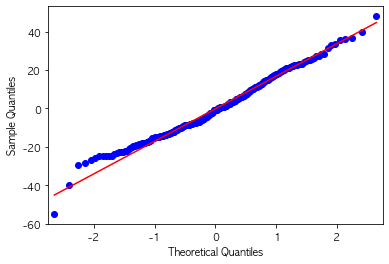

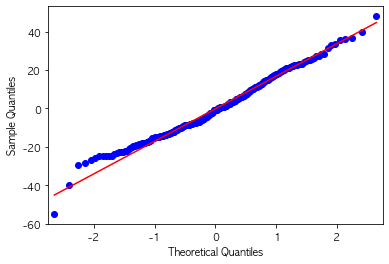

In [24]:
qqplot(reg_result.resid,line="q")

TypeError: '(slice(None, None, None), 0)' is an invalid key

In [26]:
df_raw_x = df_train[['importPriceUSA','priceUSA_TAIWAN','priceJP','priceCN','importPriceJP','stock_trend']]
df_raw_x_const = add_constant(df_raw_x)
df_vif = pd.DataFrame()
df_vif["variable"] = df_raw_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_raw_x_const,i) for i in range(df_raw_x_const.shape[1])]
#sorting VIF
df_vif.sort_values("VIF", inplace=True)
df_vif.round(3)


TypeError: '(slice(None, None, None), 0)' is an invalid key

In [ ]:
#다중공선이 10이상인 설명변수는 제거
['stock','USD_KR', 'gosi', 'JPY_KR',]

In [ ]:
# 시계열 모델에서 예측된 각각의 값들
df_expected = pd.read_csv("./data/steeldata_rate_applied20211023.csv")
#날짜형으로 변환
df_expected['date'] = pd.to_datetime(df_expected['date'], format='%Y-%m-%d')
df_expected.head()

In [ ]:
df_expected[df_expected.metric_name=='importPriceUSA'].p10

In [ ]:
df_expected.metric_name.unique()

In [ ]:
#!pip install git+https://github.com/statsmodels/statsmodels

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (40,6)
xi = list(range(len(df)))
fig = plt.figure()
ay= fig.add_subplot(111)
ay.plot(df.index, df['gosi'], label = 'gosi')
ay.plot(df.index, df['scrap_gap'] , label = '스크랩 변동폭')
ay.plot(df.index, df['weightA'], label='중량A')
ay.plot(df.index, df['importPriceJP'], label='일본 H2')
ay.plot(df.index, df['importPriceUSA'], label = "미국(대형-벌크)")

plt.xticks(xi, df['date'])
plt.legend()

ay.invert_xaxis()
ay.set_xticklabels(df['date'], rotation = 45, ha="right")

plt.show()

fig.savefig('./result_img/fig2.png', dpi = 100)

## XGBoosting

In [ ]:
# 65 Page
# 데이터 구성:Series, DataFrame
import pandas as pd
# 데이터 시각화
import matplotlib
import matplotlib.pyplot as plt
# 데이터 분할:train, test
from sklearn.model_selection import train_test_split
# 분류 XGBoosting
from xgboost import XGBClassifier 
# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV
# 모델성능 평가
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

In [ ]:
# 한글설치 (윈도우 버전)
matplotlib.rc('font', family = 'Malgun Gothic')
# 음수 표시
matplotlib.rc('axes', unicode_minus=False)

In [ ]:
# 66 Page
# 데이터 불러오기 
df_raw = pd.read_csv("C:/포스코건설/data2_2/HMEQ.csv")
df_raw.head()

In [ ]:
# 결측치 확인
df_raw.isnull().sum()

In [ ]:
# JOB 변수의 결측치는 "Other"로 대체, 
df_raw["JOB"].fillna("Other", inplace = True)
# 숫자형 변수의 결측치는 해당 변수의 평균값 입력
df_raw.fillna(df_raw.mean(), inplace=True)

In [ ]:
# get_dummies: 데이터의 문자형 변수에 대한 더미변수 생성 
df_raw_dummy = pd.get_dummies(df_raw)
df_raw_dummy.head()

In [ ]:
# train_test_split(데이터, test_size = test 데이터 비율, random_state: 랜덤)
df_train, df_test = train_test_split(df_raw_dummy, test_size = 0.3, random_state = 1234)

print("학습용 데이터 크기 : {}".format(df_train.shape))
print("평가용 데이터 크기 : {}".format(df_test.shape))

In [ ]:
# 설명변수와 목표변수를 분리
df_train_y = df_train["BAD"]
df_train_x = df_train.drop("BAD", axis = 1, inplace = False)
df_test_y = df_test["BAD"]
df_test_x = df_test.drop("BAD", axis = 1, inplace = False)

In [ ]:
# 67 Page
# xgboosting 모델 생성: XGBClassifier
xgb_uncustomized = XGBClassifier(random_state=1234)
xgb_uncustomized.fit(df_train_x, df_train_y)
# train 데이터 셋 정확도
print("학습용 데이터 정확도 : {:.3f}".format(xgb_uncustomized.score (df_train_x, df_train_y)))
# test 데이터 셋 정확도
print("평가용 데이터 정확도 : {:.3f}".format(xgb_uncustomized.score (df_test_x, df_test_y)))

In [ ]:
xgb_uncustomized

In [ ]:
# 68 Page
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# max_depth: 최대 깊이 변경
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    xgb = XGBClassifier(max_depth = v_max_depth, learning_rate=0.1, random_state=1234)
    xgb.fit(df_train_x, df_train_y)
    train_accuracy.append(xgb.score(df_train_x, df_train_y))
    test_accuracy.append(xgb.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth['max_depth'] = para_depth
df_accuracy_depth['train_accuracy'] = train_accuracy
df_accuracy_depth['test_accuracy'] = test_accuracy

In [ ]:
# 69 Page
# max_depth별 정확도 테이블
df_accuracy_depth.round(3)

In [ ]:
# 모델 정확도 그래프 확인
plt.plot(para_depth, train_accuracy, linestyle = '-', label = 'train')
plt.plot(para_depth, test_accuracy, linestyle = '-', label = 'test')
plt.xlabel('max_depth') ; plt.ylabel('accuracy')
plt.legend() ; plt.show() 

In [ ]:
# 70 Page
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# n_estimatos: 트리 수 변경: 10~150
para_n_tree = [n_tree * 10 for n_tree in range(10, 20)]

for v_n_estimators in para_n_tree:
    xgb = XGBClassifier(max_depth = 4, n_estimators = v_n_estimators, random_state = 1234)
    xgb.fit(df_train_x, df_train_y)
    train_accuracy.append(xgb.score(df_train_x, df_train_y))
    test_accuracy.append(xgb.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_n = pd.DataFrame()
df_accuracy_n["Estimators"] = para_n_tree
df_accuracy_n["TrainAccuracy"] = train_accuracy
df_accuracy_n["TestAccuracy"] = test_accuracy

In [ ]:
# 71 Page
# n_estimators별 정확도 테이블
df_accuracy_n.round(3)

In [ ]:
# 모델 정확도 그래프 확인
plt.plot(para_n_tree, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("n_estimators")
plt.legend()

In [ ]:
# 72 Page
# 최종 모델
xgb_final = XGBClassifier(max_depth = 4, n_estimators = 100, learning_rate = .1, random_state=1234)
xgb_final.fit(df_train_x, df_train_y)
# 예측
y_pred = xgb_final.predict(df_test_x)
# train 데이터 셋 정확도
print("학습용 데이터 정확도 : {:.3f}".format(xgb_final.score(df_train_x, df_train_y)))
# test 데이터 셋 정확도
print("평가용 데이터 정확도 : {:.3f}\n".format(xgb_final.score(df_test_x, df_test_y)))
# confusion matrix
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))
# classification_report
print("Confusion matrix: \n{}".format(classification_report(df_test_y, y_pred)))

In [ ]:
# 73 Page
# 변수명
v_feature_name = df_train_x.columns
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance ["Feature"] = v_feature_name
df_importance ["Importance"] = xgb_final.feature_importances_
# df_feature_importance의 테이블을 중요도 순으로 정렬
df_importance .sort_values("Importance", ascending=False, inplace = True)
df_importance .round(3)

In [ ]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림 
df_importance .sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance ))
plt.barh(y = coordinates, width = df_importance ["Importance"])
plt.yticks(coordinates, df_importance ["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

In [ ]:
# 75 Page
# XGBoost 분류기 생성
estimator = XGBClassifier(n_estimators=100, random_state=1234)

# 구하고자 하는 parameter와 범위
param_grid = {'max_depth': para_depth, 'subsample': [0.6, 0.8, 1.0]}

# AUC가 높은 최적 parameter 찾기
grid_xgb = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring='roc_auc', n_jobs=-1, cv=5)
grid_xgb.fit(df_train_x, df_train_y)
print("best estimator model: \n{}".format(grid_gb.best_estimator_))
print("\nbest parameter: \n{}".format(grid_gb.best_params_))
print("\nbest score: \n{}".format(grid_gb.best_score_.round(3)))

## 서포트벡터머신

In [ ]:
# 88 Page
# 데이터 구성:Series, DataFrame
import pandas as pd
# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib
# 데이터 scaling
from sklearn.preprocessing import StandardScaler
# 데이터 분할:train, test
from sklearn.model_selection import train_test_split
# 분류 SVM
from sklearn.svm import SVC
# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV
# 모델 성능 평가
from sklearn.metrics import confusion_matrix

In [ ]:
# 한글설치 (윈도우 버전)
matplotlib.rc('font', family = 'Malgun Gothic')
# 음수 표시
matplotlib.rc('axes', unicode_minus=False)

In [ ]:
# 89 Page
# 데이터 불러오기 
df_raw = pd.read_csv("C:/포스코건설/data2_2/HMEQ.csv")
df_raw.head()

In [ ]:
# 결측치 확인
df_raw.isnull().sum()

In [ ]:
# JOB 변수의 결측치는 "Other"로 대체
df_raw["JOB"].fillna("Other", inplace = True)
# 숫자형 변수의 결측치는 해당 변수의 평균값 입력
df_raw.fillna(df_raw.mean(), inplace=True)

In [ ]:
# get_dummies: 데이터의 문자형 변수에 대한 더미변수 생성 
df_raw_dummy = pd.get_dummies(df_raw)
df_raw_dummy.head()

In [ ]:
# train_test_split(데이터, test_size = test 데이터 비율, random_state: 랜덤)
df_train, df_test = train_test_split(df_raw_dummy, test_size = 0.3, random_state = 1234)

print("학습용 데이터 크기 : {}".format(df_train.shape))
print("평가용 데이터 크기 : {}".format(df_test.shape))

In [ ]:
# 설명변수와 목표변수를 분리
df_train_y = df_train["BAD"]
df_train_x = df_train.drop("BAD", axis = 1, inplace = False)
df_test_y = df_test["BAD"]
df_test_x = df_test.drop("BAD", axis = 1, inplace = False)

In [ ]:
# 90 Page
svm_uncustomized = SVC(random_state=1234)
svm_uncustomized.fit(df_train_x, df_train_y)
# train 데이터 셋 정확도
print("학습용 데이터 정확도 : {:.3f}".format(svm_uncustomized.score(df_train_x, df_train_y)))
# test 데이터 셋 정확도
print("평가용 데이터 정확도 : {:.3f}".format(svm_uncustomized.score(df_test_x, df_test_y)))

In [ ]:
svm_uncustomized.get_params()

In [ ]:
# 91 Page
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# c: 규제(0.01, 0.1, 1, 10)
para_c = [10 **c for c in range(-2, 2)]
# para_c = [0.1 * c for c in range(1, 10)] # C 변화 구간 변경

for v_C in para_c:
    svm = SVC(C = v_C, random_state = 1234)
    svm.fit(df_train_x, df_train_y)
    train_accuracy.append(svm.score(df_train_x, df_train_y))
    test_accuracy.append(svm.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_c = pd.DataFrame()
df_accuracy_c["C"] = para_c
df_accuracy_c["TrainAccuracy"] = train_accuracy
df_accuracy_c["TestAccuracy"] = test_accuracy

In [ ]:
# 92 Page
# C별 정확도 테이블
df_accuracy_c.round(3)

In [ ]:
# 모델 정확도 그래프 확인
plt.plot(para_c, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_c, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("C")
plt.legend()

In [ ]:
# 93 Page
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# gamma: 규제(0.01, 0.1, 1, 10)
para_gamma = [10 **gamma for gamma in range(-2, 2)]

for v_gamma in para_gamma:
    svm = SVC(gamma = v_gamma, C = 0.1, random_state = 1234)
    svm.fit(df_train_x, df_train_y)
    train_accuracy.append(svm.score(df_train_x, df_train_y))
    test_accuracy.append(svm.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_gamma = pd.DataFrame()
df_accuracy_gamma["gamma"] = para_gamma
df_accuracy_gamma["TrainAccuracy"] = train_accuracy
df_accuracy_gamma["TestAccuracy"] = test_accuracy

In [ ]:
# 94 Page
# Gamma별 정확도 테이블
df_accuracy_gamma.round(4)

In [ ]:
# 모델 정확도 그래프 확인
plt.plot(para_gamma, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_gamma, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("gamma")
plt.legend()

In [ ]:
# 95 Page
# 변수명 저장
v_feature_name = df_train_x.columns
# StandardScaler 적용 : 학습용 데이터 적용
scaler = StandardScaler()
df_scaled_train_x = scaler.fit_transform(df_train_x)
df_scaled_train_x = pd.DataFrame(df_scaled_train_x, columns=v_feature_name)
df_scaled_train_x.head()

In [ ]:
# StandardScaler 적용 : 평가용 데이터 적용
df_scaled_test_x = scaler.transform(df_test_x)
df_scaled_test_x = pd.DataFrame(df_scaled_test_x, columns=v_feature_name)
df_scaled_test_x.head()

In [ ]:
# 96 Page
svm_scaled = SVC(random_state=1234)
svm_scaled.fit(df_scaled_train_x, df_train_y)
# train 데이터 셋 정확도
print("학습용 데이터 정확도 : {:.3f}".format(svm_scaled.score(df_scaled_train_x, df_train_y)))
# test 데이터 셋 정확도
print("평가용 데이터 정확도 : {:.3f}".format(svm_scaled.score(df_scaled_test_x, df_test_y)))

In [ ]:
# 97 Page
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# c: 규제(0.01, 0.1, 1, 10)
para_c = [10 **c for c in range(-2, 2)]

for v_C in para_c:
    svm = SVC(C = v_C, random_state = 1234)
    svm.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(svm.score(df_scaled_train_x, df_train_y))
    test_accuracy.append(svm.score(df_scaled_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_c = pd.DataFrame()
df_accuracy_c["C"] = para_c
df_accuracy_c["TrainAccuracy"] = train_accuracy
df_accuracy_c["TestAccuracy"] = test_accuracy

In [ ]:
# 98 Page
# C별 정확도 테이블 
df_accuracy_c.round(3)

In [ ]:
# 모델 정확도 그래프 확인
plt.plot(para_c, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_c, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("C")
plt.legend()

In [ ]:
# 99 Page
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# gamma: 규제(0.01, 0.1, 1, 10)
para_gamma = [10 **gamma for gamma in range(-2, 2)]

for v_gamma in para_gamma:
    svm = SVC(gamma = v_gamma, C = 1, random_state = 1234)
    svm.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(svm.score(df_scaled_train_x, df_train_y))
    test_accuracy.append(svm.score(df_scaled_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_gamma = pd.DataFrame()
df_accuracy_gamma["gamma"] = para_gamma
df_accuracy_gamma["TrainAccuracy"] = train_accuracy
df_accuracy_gamma["TestAccuracy"] = test_accuracy

In [ ]:
# 100 Page
# Gamma별 정확도 테이블 
df_accuracy_gamma.round(3)

In [ ]:
# Gamma별 정확도 그래프로 확인
plt.plot(para_gamma, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_gamma, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("gamma")
plt.legend()

In [ ]:
# 101 Page
# 최종 모델
svc_final = SVC(gamma = 0.1, C = 1, random_state=1234)
svc_final.fit(df_scaled_train_x, df_train_y)
# 평가
y_pred = svc_final.predict(df_scaled_test_x)

# train 데이터 셋 정확도
print("학습용 데이터 정확도 : {:.3f}".format(svc_final.score(df_scaled_train_x, df_train_y)))
# test 데이터 셋 정확도
print("평가용 데이터 정확도 : {:.3f}\n".format(svc_final.score(df_scaled_test_x, df_test_y)))
# confusion matrix
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

In [ ]:
# 102 Page
estimator = SVC(random_state=1234)
# 구하고자 하는 parameter와 범위
param_grid = {"C": para_c,
              "gamma": para_gamma}
# 정확도가 높은 최적 parameter 찾기
grid_svc = GridSearchCV(estimator, param_grid, scoring="accuracy", n_jobs = -1)
grid_svc.fit(df_scaled_train_x, df_train_y)
print("best estimator model: \n{}".format(grid_svc.best_estimator_))
print("\nbest parameter: \n{}".format(grid_svc.best_params_))
print("\nbest score: \n{}".format(grid_svc.best_score_.round(3)))

## K-NN 분석

In [ ]:
# 111 Page
# 데이터 구성:Series, DataFrame
import pandas as pd
# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
# 데이터 scaling
from sklearn.preprocessing import StandardScaler
# 데이터 분할:train, test
from sklearn.model_selection import train_test_split
# 분류 KNN
from sklearn.neighbors import KNeighborsClassifier
# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV
# 모델 성능 평가
from sklearn.metrics import confusion_matrix

In [ ]:
# 한글설치 (윈도우 버전)
matplotlib.rc('font', family = 'Malgun Gothic')
# 음수 표시
matplotlib.rc('axes', unicode_minus=False)

In [ ]:
# 112 Page
# 데이터 불러오기 
df_raw = pd.read_csv("C:/포스코건설/data2_2/HMEQ.csv")
df_raw.head()

In [ ]:
# 결측치 확인
df_raw.isnull().sum()

In [ ]:
# JOB 변수의 결측치는 "Other"로 대체, inplace: fillna 함수 적용 후 df_raw 데이터에 저장
df_raw["JOB"].fillna("Other", inplace = True)
# 숫자형 변수의 결측치는 해당 변수의 평균값 입력: df_raw.mean() 각 변수별 평균 계산 후 결측치 대체
df_raw.fillna(df_raw.mean(), inplace=True)

In [ ]:
# get_dummies: 데이터의 문자형 변수에 대한 더미변수 생성 
df_raw_dummy = pd.get_dummies(df_raw)
# 더미변수 생성된 데이터의 상위 5개 row를 확인
df_raw_dummy.head()

In [ ]:
# train_test_split(데이터, test_size = test 데이터 비율, random_state: 랜덤)
df_train, df_test = train_test_split(df_raw_dummy, test_size = 0.3, random_state = 1234)

print("학습용 데이터 크기 : {}".format(df_train.shape))
print("평가용 데이터 크기 : {}".format(df_test.shape))

In [ ]:
# 설명변수와 목표변수를 분리
df_train_y = df_train["BAD"]
df_train_x = df_train.drop("BAD", axis = 1, inplace = False)
df_test_y = df_test["BAD"]
df_test_x = df_test.drop("BAD", axis = 1, inplace = False)

In [ ]:
# 113 Page
# KNN 모델 생성(default 설정)
knn_uncusotomized = KNeighborsClassifier()
knn_uncusotomized.fit(df_train_x, df_train_y)
# train 데이터 셋 정확도
print("학습용 데이터 정확도 : {:.3f}".format(knn_uncusotomized.score(df_train_x, df_train_y)))
# test 데이터 셋 정확도
print("평가용 데이터 정확도 : {:.3f}".format(knn_uncusotomized.score(df_test_x, df_test_y)))

In [ ]:
knn_uncusotomized.get_params()

In [ ]:
# 114 Page
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# 최대 이웃 수: 1~15
para_n_neighbors = [i for i in range(1, 16)]

for v_n_neighbors in para_n_neighbors:
    knn = KNeighborsClassifier(n_neighbors = v_n_neighbors)
    knn.fit(df_train_x, df_train_y)
    train_accuracy.append(knn.score(df_train_x, df_train_y))
    test_accuracy.append(knn.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_neighbors = pd.DataFrame()
df_accuracy_neighbors["Neighbors"] = para_n_neighbors
df_accuracy_neighbors["TrainAccuracy"] = train_accuracy
df_accuracy_neighbors["TestAccuracy"] = test_accuracy
df_accuracy_neighbors.round(3)

In [ ]:
# 115 Page
# 모델 정확도 그래프 확인
plt.plot(para_n_neighbors, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_n_neighbors, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("n_neighbors")
plt.legend()

In [ ]:
# 116 Page
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# 이웃 수
para_n_neighbors = [i for i in range(1,11)] * 2
# 가중치(uniform, distance)
para_weights = (["uniform"]) * 10 + (["distance"] * 10)
# zip( list1, list2, …)를 사용하면 list1과 list2의 인덱스별 값을 하나씩 가져옴
# 1번 loop: n_neighbors = para_n_neihtbors[0], weights = para_weights[0]
# 2번 loop: n_neighbors = para_n_neihtbors[1], weights = para_weights[1]
for (v_n_neighbors, v_weights) in zip(para_n_neighbors, para_weights):
    knn = KNeighborsClassifier(n_neighbors = v_n_neighbors, weights = v_weights)
    knn.fit(df_train_x, df_train_y)
    train_accuracy.append(knn.score(df_train_x, df_train_y))
    test_accuracy.append(knn.score(df_test_x, df_test_y))    
# 데이터 테이블로 저장
df_accuracy_weights = pd.DataFrame()
df_accuracy_weights["Neighbors"] = para_n_neighbors
df_accuracy_weights["Weights"] = para_weights
df_accuracy_weights["TrainAccuracy"] = train_accuracy
df_accuracy_weights["TestAccuracy"] = test_accuracy
df_accuracy_weights.round(3)

In [ ]:
# 117 Page
# 그림을 그리기 위해 데이터의 형태를 변환
df_accuracy_weights_pivot = df_accuracy_weights.pivot(index = "Neighbors", columns = "Weights",
                                                      values = ["TrainAccuracy", "TestAccuracy"])
df_accuracy_weights_pivot

In [ ]:
# pivot을 이용할 경우, columns와 values이 2개의 level로 이루어지므로 하나의 level로 변환
level0 = df_accuracy_weights_pivot.columns.get_level_values(0)
level1 = df_accuracy_weights_pivot.columns.get_level_values(1)
df_accuracy_weights_pivot.columns = level0 + "_" + level1
df_accuracy_weights_pivot.head()

In [ ]:
# 118 Page
# 그래프 생성. 변수별 linestyle 구분
sns.lineplot(data = df_accuracy_weights_pivot)

In [ ]:
# 119 Page
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# 이웃 수
para_n_neighbors = [i for i in range(1,11)] * 3
# 거리 계산 방법 (minkowski, euclidean, manhattan)
para_metric = ["minkowski"] * 10 + ["euclidean"] * 10 + ["manhattan"] * 10

for (v_n_neighbors, v_metric) in zip(para_n_neighbors, para_metric):
    knn = KNeighborsClassifier(n_neighbors = v_n_neighbors, metric = v_metric, weights = "uniform")
    knn.fit(df_train_x, df_train_y)
    train_accuracy.append(knn.score(df_train_x, df_train_y))
    test_accuracy.append(knn.score(df_test_x, df_test_y))    

# 데이터 테이블로 저장
df_accuracy_metric = pd.DataFrame()
df_accuracy_metric["Neighbors"] = para_n_neighbors
df_accuracy_metric["Metric"] = para_metric
df_accuracy_metric["TrainAccuracy"] = train_accuracy
df_accuracy_metric["TestAccuracy"] = test_accuracy
df_accuracy_metric.round(3)

In [ ]:
# 120 Page
# 정확도를 그래프로 그림
df_accuracy_metric_pivot = df_accuracy_metric.pivot(index = "Neighbors", columns = "Metric",
                                                    values = ["TrainAccuracy", "TestAccuracy"])

level0 = df_accuracy_metric_pivot.columns.get_level_values(0)
level1 = df_accuracy_metric_pivot.columns.get_level_values(1)
df_accuracy_metric_pivot.columns = level0 + "_" + level1
sns.lineplot(data = df_accuracy_metric_pivot)

In [ ]:
# 121 Page
# 최종 모델
knn_model = KNeighborsClassifier(n_neighbors = 4, weights = "uniform", metric = "euclidean")
knn_model.fit(df_train_x, df_train_y)
# 평가
y_pred = knn_model.predict(df_test_x)
# train 데이터 셋 정확도
print("학습용 데이터 정확도 : {0:.3f}".format(knn_model.score(df_train_x, df_train_y)))
# test 데이터 셋 정확도
print("평가용 데이터 정확도 : {0:.3f}\n".format(knn_model.score(df_test_x, df_test_y)))
# confusion matrix
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

## 나이브 베이지안

In [ ]:
# 129 Page
# 데이터 구조
import pandas as pd
# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib
# 데이터 분할:train, test
from sklearn.model_selection import train_test_split
# 분류 Naïve Bayesian
from sklearn.naive_bayes import GaussianNB
# 모델 성능 평가
from sklearn.metrics import confusion_matrix

In [ ]:
# 한글설치 (윈도우 버전)
matplotlib.rc('font', family = 'Malgun Gothic')
# 음수 표시
matplotlib.rc('axes', unicode_minus=False)

In [ ]:
# 130 Page
# 데이터 불러오기 
df_raw = pd.read_csv("C:/포스코건설/data2_2/HMEQ.csv")
df_raw.head()

In [ ]:
# 결측치 확인
df_raw.isnull().sum()

In [ ]:
# JOB 변수의 결측치는 "Other"로 대체
df_raw["JOB"].fillna("Other", inplace = True)
# 숫자형 변수의 결측치는 해당 변수의 평균값 입력
df_raw.fillna(df_raw.mean(), inplace=True)

In [ ]:
# get_dummies: 데이터의 문자형 변수에 대한 더미변수 생성 
df_raw_dummy = pd.get_dummies(df_raw)
df_raw_dummy.head()

In [ ]:
# train_test_split(데이터, test_size = test 데이터 비율, random_state: 랜덤)
df_train, df_test = train_test_split(df_raw_dummy, test_size = 0.3, random_state = 1234)

print("학습용 데이터 크기 : {}".format(df_train.shape))
print("평가용 데이터 크기 : {}".format(df_test.shape))

In [ ]:
# 설명변수와 목표변수를 분리
df_train_y = df_train["BAD"]
df_train_x = df_train.drop("BAD", axis = 1, inplace = False)
df_test_y = df_test["BAD"]
df_test_x = df_test.drop("BAD", axis = 1, inplace = False)

In [ ]:
# 131 Page
# Naïve Bayesian 모델 생성
NB_uncusotomized = GaussianNB()
NB_model = NB_uncusotomized.fit(df_train_x, df_train_y)
# train 데이터 셋 정확도
print("학습용 데이터 정확도 : {:.3f}".format(NB_model.score(df_train_x, df_train_y)))
# test 데이터 셋 정확도
print("평가용 데이터 정확도 : {:.3f}".format(NB_model.score(df_test_x, df_test_y)))

## 모델 평가

In [ ]:
# 139 Page
# 데이터 구성:Series, DataFrame
import pandas as pd
# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib
# 분류 Decision Tree
from sklearn.tree import DecisionTreeClassifier
# 분류 Random Forest
from sklearn.ensemble import RandomForestClassifier
# 분류 Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
# 분류 XGBoost
from xgboost import XGBClassifier
# 모델 성능 평가: F1 Score, ROC Curve, AUC
from sklearn.metrics import f1_score, roc_curve, auc

In [ ]:
# 한글설치 (윈도우 버전)
matplotlib.rc('font', family = 'Malgun Gothic')
# 음수 표시
matplotlib.rc('axes', unicode_minus=False)

In [ ]:
# 140 Page
# 데이터 불러오기 
df_raw = pd.read_csv("C:/포스코건설/data2_2/HMEQ.csv")
df_raw.head()

In [ ]:
# 결측치 확인
df_raw.isnull().sum()

In [ ]:
# JOB 변수의 결측치는 "Other"로 대체, inplace: fillna 함수 적용 후 df_raw 데이터에 저장
df_raw["JOB"].fillna("Other", inplace = True)
# 숫자형 변수의 결측치는 해당 변수의 평균값 입력: df_raw.mean() 각 변수별 평균 계산 후 결측치 대체
df_raw.fillna(df_raw.mean(), inplace=True)

In [ ]:
# get_dummies: 데이터의 문자형 변수에 대한 더미변수 생성 
df_raw_dummy = pd.get_dummies(df_raw)
# 더미변수 생성된 데이터의 상위 5개 row를 확인
df_raw_dummy.head()

In [ ]:
# train_test_split(데이터, test_size = test 데이터 비율, random_state: 랜덤)
df_train, df_test = train_test_split(df_raw_dummy, test_size = 0.3, random_state = 1234)

print("학습용 데이터 크기 : {}".format(df_train.shape))
print("평가용 데이터 크기 : {}".format(df_test.shape))

In [ ]:
# 설명변수와 목표변수를 분리
df_train_y = df_train["BAD"]
df_train_x = df_train.drop("BAD", axis = 1, inplace = False)
df_test_y = df_test["BAD"]
df_test_x = df_test.drop("BAD", axis = 1, inplace = False)

In [ ]:
# 141 Page
# 분석 모델
model = ["DecisionTree", "RandomForest", "GradientBoosting", "XGBoost"]

# 정확도 저장
train_accuracy = []; test_accuracy = []
# f1 score 저장
model_f1_score = []
# auc score 저장
model_auc = []

In [ ]:
# 142 Page
# 모델 생성
dt_model = DecisionTreeClassifier(max_depth = 4, min_samples_leaf = 30)
dt_model.fit(df_train_x, df_train_y)

# train 정확도
train_accuracy.append(dt_model.score(df_train_x, df_train_y))
# test 정확도
test_accuracy.append(dt_model.score(df_test_x, df_test_y))

# 예측값
y_pred = dt_model.predict(df_test_x)

# roc_curve(실제값, 예측값), fpr = FP/(FP+TN): 거짓 양성 비율, tpr = TP/(TP+FN): 진짜 양성 비율(재현율)
fpr, tpr, thresholds = roc_curve(df_test_y, y_pred)
roc_auc = auc(fpr, tpr)

# auc 저장
model_auc.append(roc_auc)

In [ ]:
# 143 Page
# roc curve 그리기, label에 auc 표시(소수점 2자리)
plt.plot(fpr, tpr, label= "AUC = %0.2f"% roc_auc)
plt.legend(loc="lower right")
plt.ylabel("TPR"); plt.xlabel("FPR")
plt.show()

In [ ]:
# f1 스코어
model_f1_score.append(f1_score(df_test_y, y_pred))

In [ ]:
# 144 Page
# 모델 생성
rf_model = RandomForestClassifier(min_samples_leaf=20, max_depth=4, n_estimators = 100, random_state=1234)
rf_model.fit(df_train_x, df_train_y)

# train 정확도
train_accuracy.append(rf_model.score(df_train_x, df_train_y))
# test 정확도
test_accuracy.append(rf_model.score(df_test_x, df_test_y))

# 예측값
y_pred = rf_model.predict(df_test_x)

# roc_curve(실제값, 예측값), fpr = FP/(FP+TN): 거짓 양성 비율, tpr = TP/(TP+FN): 진짜 양성 비율(재현율)
fpr, tpr, thresholds = roc_curve(df_test_y, y_pred)
roc_auc = auc(fpr, tpr)

# auc 저장
model_auc.append(roc_auc)

In [ ]:
# 145 Page
# roc curve 그리기, label에 auc 표시(소수점 2자리)
plt.plot(fpr, tpr, label= "AUC = %0.2f"% roc_auc)
plt.legend(loc="lower right")
plt.ylabel("TPR"); plt.xlabel("FPR")
plt.show()

In [ ]:
# f1 스코어
model_f1_score.append(f1_score(df_test_y, y_pred))

In [ ]:
# 146 Page
# 모델 생성
gb_final = GradientBoostingClassifier(min_samples_leaf = 10, max_depth = 4, n_estimators = 100,
                                      learning_rate = .1, random_state=1234)
gb_final.fit(df_train_x, df_train_y)

# train 정확도
train_accuracy.append(gb_final.score(df_train_x, df_train_y))
# test 정확도
test_accuracy.append(gb_final.score(df_test_x, df_test_y))

# 예측값
y_pred = gb_final.predict(df_test_x)

# roc_curve(실제값, 예측값), fpr = FP/(FP+TN): 거짓 양성 비율, tpr = TP/(TP+FN): 진짜 양성 비율(재현율)
fpr, tpr, thresholds = roc_curve(df_test_y, y_pred)
roc_auc = auc(fpr, tpr)

# auc 저장
model_auc.append(roc_auc)

In [ ]:
# 147 Page
# roc curve 그리기, label에 auc 표시(소수점 2자리)
plt.plot(fpr, tpr, label= "AUC = %0.2f"% roc_auc)
plt.legend(loc="lower right")
plt.ylabel("TPR"); plt.xlabel("FPR")
plt.show()

In [ ]:
# f1 스코어
model_f1_score.append(f1_score(df_test_y, y_pred))

In [ ]:
# 148 Page
# 모델 생성
xgb_final = XGBClassifier(max_depth = 4, n_estimators = 100, learning_rate = .1, random_state=1234)
xgb_final.fit(df_train_x, df_train_y)

# train 정확도
train_accuracy.append(xgb_final.score(df_train_x, df_train_y))
# test 정확도
test_accuracy.append(xgb_final.score(df_test_x, df_test_y))

# 예측값
y_pred = xgb_final.predict(df_test_x)

# roc_curve(실제값, 예측값), fpr = FP/(FP+TN): 거짓 양성 비율, tpr = TP/(TP+FN): 진짜 양성 비율(재현율)
fpr, tpr, thresholds = roc_curve(df_test_y, y_pred)
roc_auc = auc(fpr, tpr)

# auc 저장
model_auc.append(roc_auc)

In [ ]:
# 149 Page
# roc curve 그리기, label에 auc 표시(소수점 2자리)
plt.plot(fpr, tpr, label= "AUC = %0.2f"% roc_auc)
plt.legend(loc="lower right")
plt.ylabel("TPR"); plt.xlabel("FPR")
plt.show()

In [ ]:
# f1 스코어
model_f1_score.append(f1_score(df_test_y, y_pred))

In [ ]:
# 150 Page
# 모델별 정확도 표
df_eval = pd.DataFrame(index = model)
df_eval["TrainAccuracy"] = train_accuracy
df_eval["TestAccuracy"] = test_accuracy
df_eval["F1Score"] = model_f1_score
df_eval["AUC"] = model_auc
df_eval.round(3)

In [ ]:
# 정확도 bar plot 생성
df_eval.plot.bar(rot = 0)
plt.legend(loc="lower right")
plt.grid(axis = "y")